# SimPy for Manpower Analysis

The following is a demonstration of the SimPy module in Python for use in manpower analysis.  In this toy example, Corporate Co is a workcenter with the following processes:
- Process Alpha: Fixed Workload, Recurs Daily for 45 minutes
- Process Bravo: Fixed Workload, Recurs Every Monday for 90 minutes
- Process Charlie: Variable workload, Input: Customer Arrival, Time: Normally Distributed with average of 12 min/std. dev. of 4 min.
- Process Delta: Variable workload, Input: Customer Arrival, Time: Exponentially Distributed with average of 8 min
- Process Echo: Variable workload, Input: Customer Arrival, Time: Normally Distributed with average of 25 min/std. dev. of 7 min.

Historical records suggest that when customers arrive to the Corporate Co., they tend to need Process Charlie 25% of the time, Process Delta 45% of the time, and Process Echo 30% of the time.  Sign in records suggest that customers arrive at a steady rate throughout the day, with the time between arrivals being exponentially distributed with an average of 3 min between arrivals.  Additionally, we note that each morning, there are about 3 customers already in line when the office first opens.  All employees in Corporate Co are available to complete any task.  Corporate Co.'s office is open from 0700 - 1500, Monday through Friday.

The following model will be constructed to simulate this scenario across one, 30-day month (starting on a Monday).  In this analysis, we want to measure the wait time of customers as it relates to manpower levels.

How many employee work at Corporate Co?3
How many days would you like the simulation to run?30
Running simulation... 
The average wait time is 109 minutes and 30 seconds


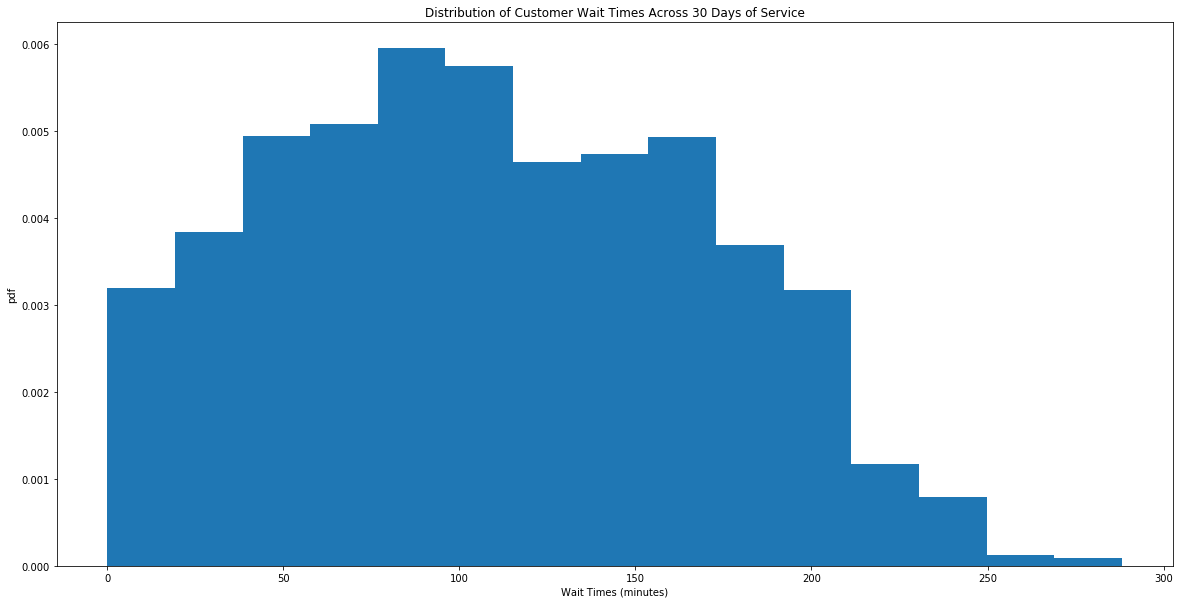

In [47]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import simpy
import statistics

# Initialize tracking lists
wait_times = []                 

# Define the class 'CorporateCo' which houses functions for each process
# When a process is called, the simulator calls the particular process and adjusts the time...
# ...to reflect the process time as defined by our previously determined distributions.
class CorporateCo(object):
    # Set each team as attributes of service when the class is called
    def __init__(self, env, num_employee):
        self.env = env
        self.employee = simpy.Resource(env, num_employee)
        
    # Define functions for each process and set the process time
    def alpha(self, customer):
        prcs_time = 45                                       # Process Alpha: 45 minutes
        yield self.env.timeout(prcs_time)
        
    def bravo(self, customer):
        prcs_time = 90                                       # Process Bravo: 90 minutes
        yield self.env.timeout(prcs_time)
        
    def charlie(self, customer):
        prcs_time = abs(np.random.normal(12, 4))             # Process Charlie: norm(12, 4)
        yield self.env.timeout(prcs_time)
        
    def delta(self, customer):
        prcs_time = np.random.exponential(8)                 # Process Delta: exp(8)
        yield self.env.timeout(prcs_time)
        
    def echo(self, customer):                                # Process Echo: norm(25, 7)
        prcs_time = abs(np.random.normal(25, 7))
        yield self.env.timeout(prcs_time)

# Define the function visit_office to direct the actions of the customer once they arrive
def visit_office(env, customer, office):
    # Set arrival_time equal to the time this function starts (i.e., customer arrives)
    arrival_time = env.now
        
    # Draw a random number from 0 to 1
    rand_draw = random.random()
    
    # Based on the random number and the probabilities of different services being requested...
    # ...customers will be funneled to the previously defined functions in class CorporateCo
    # Customers will request the service from a team member and wait until it is provided
    # Once a team member becomes available, the wait time will be calculated and stored
    if rand_draw <= 0.25:                                 # 25% of customers need Process Charlie
        with office.employee.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            yield env.process(office.charlie(customer))
    
    elif rand_draw <= 0.70:                               # 45% of customers need Process Delta
        with office.employee.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            yield env.process(office.delta(customer))

    else:
        with office.employee.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            yield env.process(office.echo(customer))
            
# Define the function visit_office_day to direct daily workload
def visit_office_daily(env, customer, office):
    with office.employee.request() as request:
        yield request
        yield env.process(office.alpha(customer))
        
# Define the function visit_office_monthly to direct daily workload
def visit_office_monthly(env, customer, office):
    with office.employee.request() as request:
        yield request
        yield env.process(office.bravo(customer))

# Define the function run_office which inputs the simulation's workforce, initializes the...
# ...customers waiting in the lobby when the office opens, and then periodically sends...
# ...customers into the office throughout the day.
def run_office(env, num_employee, day):
    office = CorporateCo(env, num_employee)
    
    # Initializes the lobby at the start of the day
    num_early_cust = 3
    for customer in range(num_early_cust):
        env.process(visit_office(env, customer, office))

    # Call daily workload
    env.process(visit_office_daily(env, customer, office))
    
    # Call weekly workload
    if day in [0, 7, 14, 21, 28]:                           # If Monday (every 7 days)
        env.process(visit_office_monthly(env, customer, office))
        
    # Evenly spaces the daily customers across the day and adds them to the simulation
    while True:
        yield env.timeout(np.random.exponential(3))     # Customers arrive every 3 minutes (expon. distributed)
        
        customer += 1
        env.process(visit_office(env, customer, office))

# Define function calculate_wait_times to compute the average wait time at the each of the...
# ...simulation and convert it to a more readable format.
def calculate_wait_times(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# Define function get_user_input asks the user to input the manning levels of each team at...
# ...the start of the simulation.
def get_user_input():
    num_employee = int(input('Input # of Corporate Co employees:'))
    return num_employee

# The function main serves as the core function which initiates the simulation and sets the...
# ...overarching parameters
def main():
    # Seed the random number generators to make results reproducible 
    random.seed(42)
    np.random.seed(42)
    
    # Call the get_user_input() function to gather information from user
    num_employee = int(input('How many employee work at Corporate Co?'))
    
    # Set the number of days you want the simulation to run for
    num_days = int(input('How many days would you like the simulation to run?'))
    
    for day in range(num_days):        
        # Run simulation and set the duration (in minutes) for the simulation to run
        env = simpy.Environment()
        env.process(run_office(env, num_employee, day))
        env.run(until = 540)                            # Each day of simulation runs 540 minutes (0700 - 1500)

    # View the results
    mins, secs = calculate_wait_times(wait_times)
    print(
    'Running simulation...',
    f'\nThe average wait time is {mins} minutes and {secs} seconds'
    )
    
    # Visualize wait times throughout the day
    plt.figure(figsize = (20, 10))
    plt.hist(wait_times, density = True, bins = 15)
    plt.xlabel('Wait Times (minutes)')
    plt.ylabel('pdf')
    plt.title(f'Distribution of Customer Wait Times Across {num_days} Days of Service')
    plt.show()

# Calls the main function to start the simulation
if __name__ == '__main__':
    main()

If we would like the simulation to output information for each process, such as how much wait time was associated, when the process started, and how long the process took to complete, we can accomplish this with a few extra steps.

How many employee work at Corporate Co?3
How many days would you like the simulation to run?30
Running simulation... 
The average wait time is 109 minutes and 30 seconds


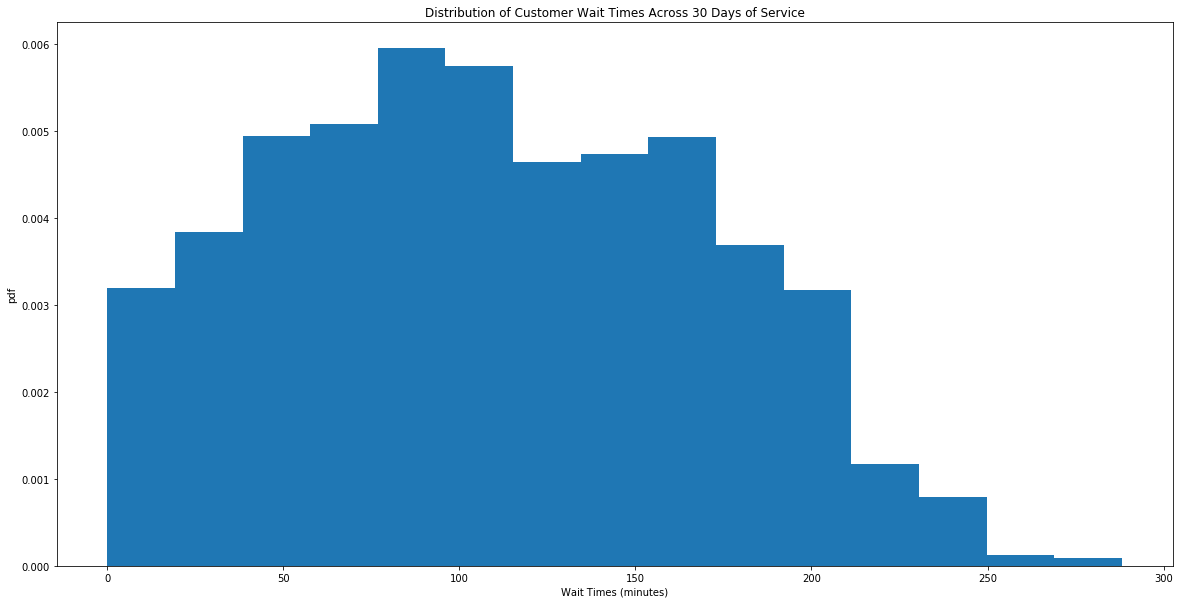

,Day,Process,Wait,Start Time,Duration,Departure Time
0,0,Delta,0.000000,0.000000,1.356999,1.356999
1,0,Charlie,0.000000,0.000000,14.590754,14.590754
2,0,Delta,0.000000,0.000000,24.080971,24.080971
3,0,Charlie,22.673167,24.080971,18.092119,42.173091
4,0,Alpha,1.356999,1.356999,45.000000,46.356999
...,...,...,...,...,...,...
3440,29,Delta,202.609797,510.859908,3.572073,514.431981
3441,29,Echo,199.004606,499.352576,15.184628,514.537204
3442,29,Delta,205.824226,514.431981,17.233167,531.665148
3443,29,Echo,207.534009,510.221405,25.186004,535.407408


In [66]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import simpy
import statistics

roster = []

# Initialize tracking lists
wait_times = []                 

# Define the class 'CorporateCo' which houses functions for each process
# When a process is called, the simulator calls the particular process and adjusts the time...
# ...to reflect the process time as defined by our previously determined distributions.
class CorporateCo(object):
    # Set each team as attributes of service when the class is called
    def __init__(self, env, num_employee):
        self.env = env
        self.employee = simpy.Resource(env, num_employee)
        
    # Define functions for each process and set the process time
    def alpha(self, env, customer, day, wait):
        prcs_time = 45                                       # Process Alpha: 45 minutes
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Alpha', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def bravo(self, env, customer, day, wait):
        prcs_time = 90                                       # Process Bravo: 90 minutes
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Bravo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def charlie(self, env, customer, day, wait):
        prcs_time = abs(np.random.normal(12, 4))             # Process Charlie: norm(12, 4)
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Charlie', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def delta(self, env, customer, day, wait):
        prcs_time = np.random.exponential(8)                 # Process Delta: exp(8)
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Delta', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def echo(self, env, customer, day, wait):                                # Process Echo: norm(25, 7)
        prcs_time = abs(np.random.normal(25, 7))
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Echo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})

# Define the function visit_office to direct the actions of the customer once they arrive
def visit_office(env, customer, office, day):
    # Set arrival_time equal to the time this function starts (i.e., customer arrives)
    arrival_time = env.now
        
    # Draw a random number from 0 to 1
    rand_draw = random.random()
    
    # Based on the random number and the probabilities of different services being requested...
    # ...customers will be funneled to the previously defined functions in class CorporateCo
    # Customers will request the service from a team member and wait until it is provided
    # Once a team member becomes available, the wait time will be calculated and stored
    if rand_draw <= 0.25:                                 # 25% of customers need Process Charlie
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.charlie(env, customer, day, wait))
    
    elif rand_draw <= 0.70:                               # 45% of customers need Process Delta
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.delta(env, customer, day, wait))

    else:
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.echo(env, customer, day, wait))
            
# Define the function visit_office_day to direct daily workload
def visit_office_daily(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.alpha(env, customer, day, wait))
        
# Define the function visit_office_monthly to direct daily workload
def visit_office_monthly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.bravo(env, customer, day, wait))

# Define the function run_office which inputs the simulation's workforce, initializes the...
# ...customers waiting in the lobby when the office opens, and then periodically sends...
# ...customers into the office throughout the day.
def run_office(env, num_employee, day):
    office = CorporateCo(env, num_employee)
    
    # Initializes the lobby at the start of the day
    num_early_cust = 3
    for customer in range(num_early_cust):
        env.process(visit_office(env, customer, office, day))

    # Call daily workload
    env.process(visit_office_daily(env, customer, office, day))
    
    # Call weekly workload
    if day in [0, 7, 14, 21, 28]:                           # If Monday (every 7 days)
        env.process(visit_office_monthly(env, customer, office, day))
        
    # Evenly spaces the daily customers across the day and adds them to the simulation
    while True:
        yield env.timeout(np.random.exponential(3))     # Customers arrive every 3 minutes (expon. distributed)
        
        customer += 1
        env.process(visit_office(env, customer, office, day))

# Define function calculate_wait_times to compute the average wait time at the each of the...
# ...simulation and convert it to a more readable format.
def calculate_wait_times(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# Define function get_user_input asks the user to input the manning levels of each team at...
# ...the start of the simulation.
def get_user_input():
    num_employee = int(input('Input # of Corporate Co employees:'))
    return num_employee

# The function main serves as the core function which initiates the simulation and sets the...
# ...overarching parameters
def main():
    # Seed the random number generators to make results reproducible 
    random.seed(42)
    np.random.seed(42)
    
    # Call the get_user_input() function to gather information from user
    num_employee = int(input('How many employee work at Corporate Co?'))
    
    # Set the number of days you want the simulation to run for
    num_days = int(input('How many days would you like the simulation to run?'))
    
    for day in range(num_days):        
        # Run simulation and set the duration (in minutes) for the simulation to run
        env = simpy.Environment()
        env.process(run_office(env, num_employee, day))
        env.run(until = 540)                            # Each day of simulation runs 540 minutes (0700 - 1500)

    # View the results
    mins, secs = calculate_wait_times(wait_times)
    print(
    'Running simulation...',
    f'\nThe average wait time is {mins} minutes and {secs} seconds'
    )
    
    # Visualize wait times throughout the day
    plt.figure(figsize = (20, 10))
    plt.hist(wait_times, density = True, bins = 15)
    plt.xlabel('Wait Times (minutes)')
    plt.ylabel('pdf')
    plt.title(f'Distribution of Customer Wait Times Across {num_days} Days of Service')
    plt.show()
    
    # Convert the process roster into a dataframe and display
    process_roster = pd.DataFrame(roster)
    display(process_roster)

# Calls the main function to start the simulation
if __name__ == '__main__':
    main()
    